In [233]:
import gurobipy as gp
from gurobipy import GRB
import json
import pandas as pd
import numpy as np

In [234]:
with open(r"C:\Users\Pulin\Desktop\Optimisation_PowerSystems_Assignment1\data\question_1c\appliance_params.json", "r") as f:
    data = json.load(f)


In [235]:
data

{'DER': [{'DER_id': 'PV_01',
   'DER_type': 'PV',
   'max_power_kW': 3.0,
   'min_power_ratio': 0.0,
   'max_ramp_rate_up_ratio': 1.0,
   'max_ramp_rate_down_ratio': 1.0}],
 'load': [{'load_type': 'fully flexible load',
   'load_id': 'FFL_01',
   'max_load_kWh_per_hour': 3.0,
   'min_load_ratio': 0.0,
   'max_ramp_rate_up_ratio': 1.0,
   'max_ramp_rate_down_ratio': 1.0,
   'min_on_time_h': 0,
   'min_off_time_h': 0}],
 'storage': [{'storage_id': 'BESS_01',
   'storage_capacity_kWh': 6.0,
   'max_charging_power_ratio': 0.15,
   'max_discharging_power_ratio': 0.3,
   'charging_efficiency': 0.9,
   'discharging_efficiency': 0.9}]}

In [236]:
with open(r"C:\Users\Pulin\Desktop\Optimisation_PowerSystems_Assignment1\data\question_1c\bus_params.json", "r") as f:
    data2 = json.load(f)


In [237]:
data2

[{'bus_ID': 'Bus1',
  'import_tariff_DKK/kWh': 0.5,
  'export_tariff_DKK/kWh': 0.4,
  'max_import_kW': 1000,
  'max_export_kW': 500,
  'penalty_excess_import_DKK/kWh': 10,
  'penalty_excess_export_DKK/kWh': 10,
  'energy_price_DKK_per_kWh': [1.1,
   1.05,
   1.0,
   0.9,
   0.85,
   1.01,
   1.05,
   1.2,
   1.4,
   1.6,
   1.5,
   1.1,
   1.05,
   1.0,
   0.95,
   1.0,
   1.2,
   1.5,
   2.1,
   2.5,
   2.2,
   1.8,
   1.4,
   1.2]}]

In [238]:
with open(r"C:\Users\Pulin\Desktop\Optimisation_PowerSystems_Assignment1\data\question_1c\DER_production.json", "r") as f:
    data3 = json.load(f)

data3

[{'consumer_ID': 'C1',
  'DER_type': 'solar',
  'hourly_profile_ratio': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.05,
   0.14,
   0.21,
   0.15,
   0.12,
   0.21,
   0.25,
   0.85,
   0.75,
   0.55,
   0.43,
   0.23,
   0.05,
   0.25,
   0.25,
   0.0,
   0.0,
   0.0,
   0.0]}]

In [239]:
def get_param(data, key, category=None, idx=0, subcategory=None, subidx=0):
    """
    General function to access a value from a (possibly nested) data dictionary.

    Args:
        data (dict or list): The loaded JSON dictionary or list of dicts.
        key (str): The key to access.
        category (str or None): The category (e.g., "DER", "load", "storage") if nested, else None.
        idx (int): Index in the list (default 0).
        subcategory (str or None): Optional subcategory key (e.g., "load_preferences").
        subidx (int): Index in the subcategory list (default 0).

    Returns:
        The value for the requested key, or None if not found.
    """
    try:
        if category and subcategory:
            return data[category][idx][subcategory][subidx][key]
        elif category:
            return data[category][idx][key]
        elif subcategory:
            return data[idx][subcategory][subidx][key]
        elif isinstance(data, list):
            return data[idx][key]
        else:
            return data[key]
    except (KeyError, IndexError, TypeError):
        print(f"Could not find {key} in the provided path.")
        return None

# Example usage:
# For data4 structure:
# get_param(data4, "hourly_profile_ratio", subcategory="load_preferences")

In [240]:
"Solar Power";
max_power_solar = get_param(data, "max_power_kW", category="DER")
min_power_ratio = get_param(data, "min_power_ratio", category="DER")
max_ramp_up_rate_solar  = get_param(data, "max_ramp_rate_up_ratio", category="DER")
max_ramp_down_rate_solar = get_param(data, "max_ramp_rate_down_ratio", category="DER")

#------------------------------------
"Flexible Load";
max_load_FFL = get_param(data, "max_load_kWh_per_hour", category="load")
min_load_FFL = get_param(data, "min_load_ratio", category="load")
max_ramp_up_rate_FFL = get_param(data, "max_ramp_rate_up_ratio", category="load")
max_ramp_down_rate_FFL = get_param(data, "max_ramp_rate_down_ratio", category="load")
min_on_time_h = get_param(data, "min_on_time_h", category="load")
min_off_time_h = get_param(data, "min_off_time_h", category="load")

#------------------------------------------------
"Battery Storage";
storage_capacity = get_param(data, "storage_capacity_kWh", category="storage")
max_charging_power_ratio = get_param(data, "max_charging_power_ratio", category="storage")
max_discharging_power_ratio = get_param(data, "max_discharging_power_ratio", category="storage")
charging_efficiency = get_param(data, "charging_efficiency", category="storage")
discharging_efficiency = get_param(data, "discharging_efficiency", category="storage")


In [241]:

price_import = get_param(data2, "import_tariff_DKK/kWh")  
price_export = get_param(data2, "export_tariff_DKK/kWh")  
max_import = get_param(data2, "max_import_kW")  
max_export = get_param(data2, "max_export_kW")  
penalty_excess_import = get_param(data2, "penalty_excess_import_DKK/kWh") 
penalty_excess_export = get_param(data2, "penalty_excess_export_DKK/kWh")  


electricity_price = get_param(data2, "energy_price_DKK_per_kWh")  

In [242]:
Solar_CF = get_param(data3,"hourly_profile_ratio")
Solar_CF

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05,
 0.14,
 0.21,
 0.15,
 0.12,
 0.21,
 0.25,
 0.85,
 0.75,
 0.55,
 0.43,
 0.23,
 0.05,
 0.25,
 0.25,
 0.0,
 0.0,
 0.0,
 0.0]

In [243]:
with open(r"C:\Users\Pulin\Desktop\Optimisation_PowerSystems_Assignment1\data\question_1c\usage_preferences.json", "r") as f:
    data4 = json.load(f)

data4

[{'consumer_ID': 'C1',
  'grid_preferences': None,
  'DER_preferences': None,
  'load_preferences': [{'load_id': 'FFL_01',
    'min_total_energy_per_day_hour_equivalent': None,
    'max_total_energy_per_day_hour_equivalent': None,
    'hourly_profile_ratio': [0.055,
     0.04,
     0.04,
     0.04,
     0.075,
     0.48,
     0.76,
     0.8,
     0.63,
     0.22,
     0.25,
     0.35,
     0.3,
     0.28,
     0.45,
     0.65,
     0.78,
     0.9,
     0.98,
     0.88,
     0.075,
     0.15,
     0.075,
     0.055]}],
  'storage_preferences': [{'storage_id': 'BESS_01',
    'initial_soc_ratio': 0.5,
    'final_soc_ratio': 0.5}],
  'heat_pump_preferences': None}]

In [244]:
load_profile_consumer = get_param(data4, "hourly_profile_ratio", subcategory="load_preferences")
SOC_initial = get_param(data4, "initial_soc_ratio", subcategory="storage_preferences")
SOC_final = get_param(data4, "final_soc_ratio", subcategory="storage_preferences")


In [245]:
load_profile_consumer

[0.055,
 0.04,
 0.04,
 0.04,
 0.075,
 0.48,
 0.76,
 0.8,
 0.63,
 0.22,
 0.25,
 0.35,
 0.3,
 0.28,
 0.45,
 0.65,
 0.78,
 0.9,
 0.98,
 0.88,
 0.075,
 0.15,
 0.075,
 0.055]

In [246]:
SOC_initial, SOC_final

(0.5, 0.5)

In [247]:
max_charging_power_ratio, storage_capacity

(0.15, 6.0)

In [248]:
t = range(len(Solar_CF))
t

range(0, 24)

In [249]:
max_power_solar

3.0

In [250]:
SOC_initial

0.5

In [251]:
max_ramp_up_rate_FFL 

1.0

In [252]:
max_charging_power_ratio

0.15

In [253]:
storage_capacity

6.0

In [254]:
load_profile_consumer

[0.055,
 0.04,
 0.04,
 0.04,
 0.075,
 0.48,
 0.76,
 0.8,
 0.63,
 0.22,
 0.25,
 0.35,
 0.3,
 0.28,
 0.45,
 0.65,
 0.78,
 0.9,
 0.98,
 0.88,
 0.075,
 0.15,
 0.075,
 0.055]

In [255]:
max_load_FFL

3.0

In [256]:
import gurobipy as gp
from gurobipy import GRB

def prosumer_optimization(price_import, price_export, electricity_price,
                          penalty_excess_import, penalty_excess_export,weight_discomfort):
    """
    Prosumer optimization model to minimize procurement cost & penalties, including battery storage and SOC.
    """

    # Create model
    model = gp.Model("Prosumer_Continuous")

    # Decision variables
    x_imports = model.addVars(t, name="imported_power_kW", lb=0, ub=GRB.INFINITY)
    x_exports = model.addVars(t, name="exported_power_kW", lb=0, ub=GRB.INFINITY)
    x_FFL = model.addVars(t, name="FFL_consumption_kW", lb=0, ub=1)  # scaled 0-1
    x_solar = model.addVars(t, name="solar_power_kW", lb=0)
    z_import_excess = model.addVars(t, name="excess_import_kW", lb=0)
    z_export_excess = model.addVars(t, name="excess_export_kW", lb=0)
    delta_FFL = model.addVars(t, name="delta_FFL", lb=0, ub=GRB.INFINITY)
    SOC_t = model.addVars(t, name="SOC", lb=0, ub=storage_capacity)
    x_charging = model.addVars(t, name="charging_power_kW", lb=0, ub=max_charging_power_ratio * storage_capacity) 
    x_discharging = model.addVars(t, name="discharging_power_kW", lb=0, ub=max_discharging_power_ratio * storage_capacity)

    
    # Hourly constraints?
    for i in t:
        # FFL min/max
        model.addConstr(x_FFL[i] * max_load_FFL >= min_load_FFL, name=f"FFL_min_{i}")
        model.addConstr(x_FFL[i] * max_load_FFL <= max_load_FFL, name=f"FFL_max_{i}")

        # Solar production limit
        model.addConstr(x_solar[i] <= Solar_CF[i] * max_power_solar, name=f"solar_max_{i}")

        # Energy balance (now includes battery charging/discharging)
        model.addConstr(
            x_imports[i] - x_exports[i] + x_solar[i] + x_discharging[i] - x_charging[i] == x_FFL[i] * max_load_FFL,
            name=f"energy_balance_{i}"
        )

        # Excess import/export
        model.addConstr(z_import_excess[i] >= x_imports[i] - max_import, name=f"excess_import_{i}")
        model.addConstr(z_export_excess[i] >= x_exports[i] - max_export, name=f"excess_export_{i}")

        #model.addConstr(x_charging[i] <= max_charging_power_ratio * storage_capacity, name=f"charging_limit_{i}")
        #model.addConstr(x_discharging[i] <= max_discharging_power_ratio * storage_capacity, name=f"discharging_limit_{i}")

        # Discomfort per hour from load profile
        model.addConstr(delta_FFL[i] >= (x_FFL[i] - load_profile_consumer[i]) * max_load_FFL, name=f"discomfort_pos_{i}")
        model.addConstr(delta_FFL[i] >= (load_profile_consumer[i] - x_FFL[i]) * max_load_FFL, name=f"discomfort_neg_{i}")

        #model.addConstr(x_FFL[i] == load_profile_consumer[i]) 
     
        # SOC bounds and dynamics
        if i == 0:
            model.addConstr(SOC_t[i] == SOC_initial * storage_capacity, name="initial_soc") # kWh
        if i == 24:
            model.addConstr(SOC_t[i] == SOC_final * storage_capacity, name="final_soc") # kWh

        # Final SOC constraint (at last hour)
        if i == t[-1]:
            model.addConstr(SOC_t[i] == SOC_final * storage_capacity, name="final_soc") # kWh

        # Ramp constraints for FFL + Solar,  [t - 1] -> [t]
        if i > 0:
            model.addConstr(
                (x_FFL[i] * max_load_FFL) - (x_FFL[i-1] * max_load_FFL) <= max_ramp_up_rate_FFL * max_load_FFL,
                name=f"FFL_ramp_up_{i}"
            )
            model.addConstr(
                (x_FFL[i-1] * max_load_FFL) - (x_FFL[i] * max_load_FFL) <= max_ramp_down_rate_FFL * max_load_FFL,
                name=f"FFL_ramp_down_{i}"
            )

            # Ramp constraints for solar
            model.addConstr(
                x_solar[i] - x_solar[i-1] <= max_ramp_up_rate_solar * max_power_solar,
                name=f"solar_ramp_up_{i}"
            )
            model.addConstr(
                x_solar[i-1] - x_solar[i] <= max_ramp_down_rate_solar * max_power_solar,
                name=f"solar_ramp_down_{i}"
            )
    

            # SOC dynamics
            model.addConstr(
                SOC_t[i] == SOC_t[i-1] + (x_charging[i - 1] * charging_efficiency) - (x_discharging[i - 1] / discharging_efficiency),
                name=f"SOC_dynamics_{i}"
            )

          # Compute total profit (same as your objective)

        
# Minimum total daily FFL energy
    model.addConstr(    
    gp.quicksum(x_FFL[i] * max_load_FFL for i in t) >= 0 * max_load_FFL,
    name="FFL_min_total_energy"
)
        
    # Objective: minimize cost + penalties
    model.setObjective(
    gp.quicksum(
        (-price_import - electricity_price[i]) * x_imports[i]
        - penalty_excess_import * z_import_excess[i]
        + (electricity_price[i] - price_export) * x_exports[i]
        -penalty_excess_export * z_export_excess[i] - weight_discomfort*delta_FFL[i]  # Penalty for discomfort
        for i in t
    ),
    sense=GRB.MAXIMIZE
    )
    # Solve
    model.optimize()

    # === Define PROFIT Expression ===
    profit_expr = gp.quicksum(
        (-price_import - electricity_price[i]) * x_imports[i]
        - penalty_excess_import * z_import_excess[i]
        + (electricity_price[i] - price_export) * x_exports[i]
        - penalty_excess_export * z_export_excess[i]
        for i in t
    )


    total_discomfort = gp.quicksum(delta_FFL[i] for i in t)    



    return model, x_imports, x_exports, x_FFL, x_solar, delta_FFL, SOC_t, x_charging, x_discharging, profit_expr.getValue(), total_discomfort.getValue()

In [257]:
price_import, price_export,penalty_excess_import, penalty_excess_export

(0.5, 0.4, 10, 10)

In [258]:
# Run the optimization and get the variables
model, x_imports, x_exports, x_FFL, x_solar, delta_FFL, SOC_t, x_charging, x_discharging, profit, total_discomfort = prosumer_optimization(
    price_import, price_export, electricity_price,
    penalty_excess_import, penalty_excess_export, weight_discomfort=0)

# Print all outputs per hour
print("Hour | Import(kW) | Export(kW) | FFL(kW) | Solar(kW) | Delta_FFL | SOC(kWh) | Charging(kW) | Discharging(kW)")
for i in t:
    print(f"{i:>4} | "
          f"{x_imports[i].X:>10.3f} | "
          f"{x_exports[i].X:>10.3f} | "
          f"{x_FFL[i].X * max_load_FFL:>7.3f} | "
          f"{x_solar[i].X:>8.3f} | "
          f"{delta_FFL[i].X:>9.3f} | "
          f"{SOC_t[i].X:>8.3f} | "
          f"{x_charging[i].X:>11.3f} | "
          f"{x_discharging[i].X:>13.3f}")

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 310 rows, 240 columns and 710 nonzeros
Model fingerprint: 0x2ce32a87
Coefficient statistics:
  Matrix range     [9e-01, 3e+00]
  Objective range  [4e-01, 1e+01]
  Bounds range     [9e-01, 6e+00]
  RHS range        [1e-01, 1e+03]
Presolve removed 217 rows and 54 columns
Presolve time: 0.00s
Presolved: 93 rows, 186 columns, 300 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2060000e+31   3.200000e+31   2.206000e+01      0s
      70    1.6728840e+01   0.000000e+00   0.000000e+00      0s

Solved in 70 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.672884000e+01
Hour | Import(kW) | Export(kW) | FFL(kW) | Solar(kW) | Delta_FFL | SOC(kWh) | Charging(kW) | Disc

In [259]:
"Profit in EUR";
profit
"Total discomfort (kw)"
total_discomfort

27.945000000000004

In [260]:
# --- Print primal (variable) and dual (constraint) together ---
print("=== Primal Variables ===")
for v in model.getVars():
    print(f"{v.VarName:>20} | Primal: {v.X:.3f}")

print("\n=== Constraints with Duals ===")
for c in model.getConstrs():
    print(f"{c.ConstrName:>20} | Dual: {c.Pi:.3f}")

=== Primal Variables ===
imported_power_kW[0] | Primal: 0.000
imported_power_kW[1] | Primal: 0.000
imported_power_kW[2] | Primal: 0.000
imported_power_kW[3] | Primal: 0.000
imported_power_kW[4] | Primal: 0.000
imported_power_kW[5] | Primal: 0.000
imported_power_kW[6] | Primal: 0.000
imported_power_kW[7] | Primal: 0.000
imported_power_kW[8] | Primal: 0.000
imported_power_kW[9] | Primal: 0.000
imported_power_kW[10] | Primal: 0.000
imported_power_kW[11] | Primal: 0.000
imported_power_kW[12] | Primal: 0.000
imported_power_kW[13] | Primal: 0.000
imported_power_kW[14] | Primal: 0.000
imported_power_kW[15] | Primal: 0.000
imported_power_kW[16] | Primal: 0.000
imported_power_kW[17] | Primal: 0.000
imported_power_kW[18] | Primal: 0.000
imported_power_kW[19] | Primal: 0.000
imported_power_kW[20] | Primal: 0.000
imported_power_kW[21] | Primal: 0.000
imported_power_kW[22] | Primal: 0.000
imported_power_kW[23] | Primal: 0.000
exported_power_kW[0] | Primal: 0.000
exported_power_kW[1] | Primal: 0.000

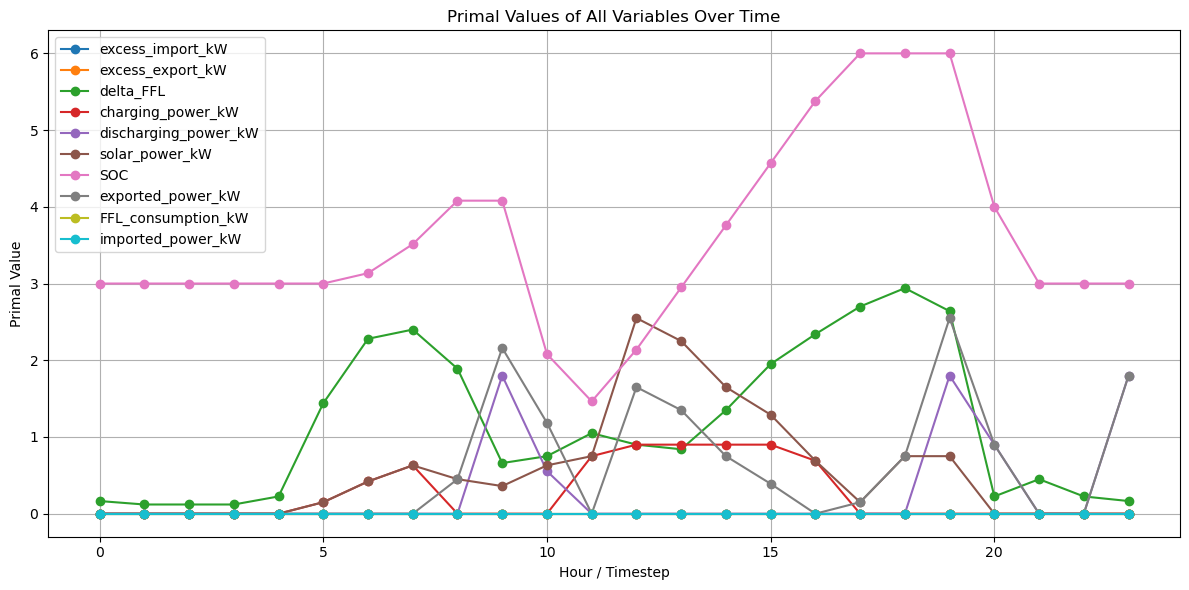

In [261]:
import matplotlib.pyplot as plt

# Extract all variables
vars = model.getVars()

# If variables are time-indexed, group them by type prefix
# Example variable names: "FFL[0]", "solar[0]", etc.
var_types = set([v.VarName.split('[')[0] for v in vars])

plt.figure(figsize=(12,6))

for var_type in var_types:
    # Get all variables of this type
    type_vars = [v for v in vars if v.VarName.startswith(var_type)]
    # Sort by timestep
    type_vars_sorted = sorted(type_vars, key=lambda v: int(v.VarName.split('[')[1].split(']')[0]))
    # Extract values
    primal_values = [v.X for v in type_vars_sorted]
    hours = list(range(len(primal_values)))

    # Plot
    plt.plot(hours, primal_values, marker='o', linestyle='-', label=var_type)

plt.xlabel("Hour / Timestep")
plt.ylabel("Primal Value")
plt.title("Primal Values of All Variables Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



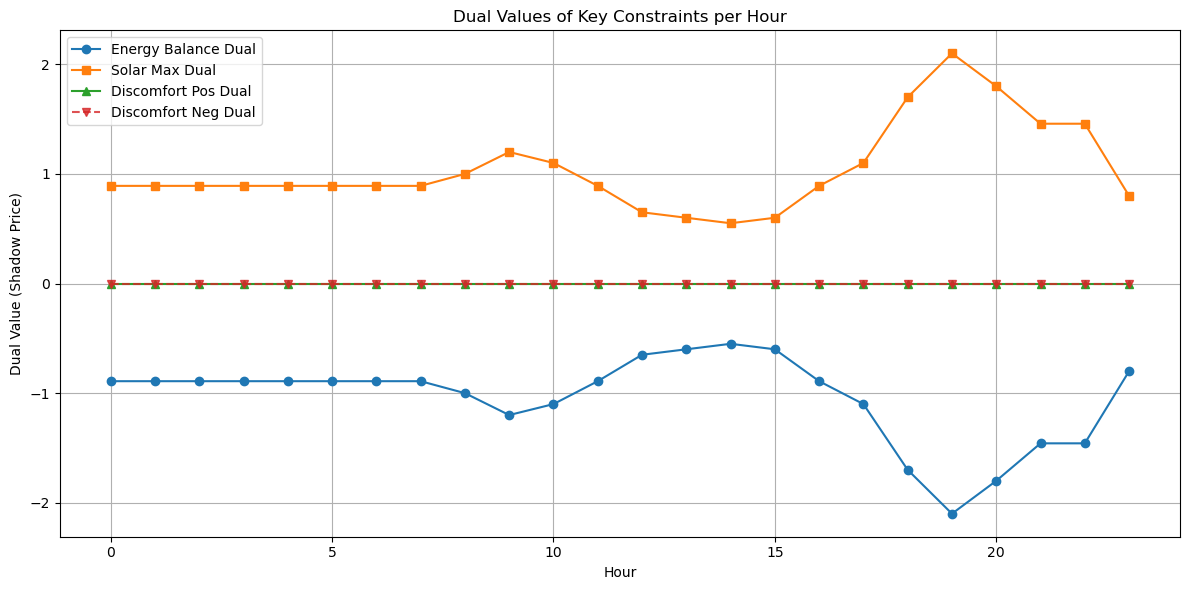

In [262]:
import matplotlib.pyplot as plt

# Extract hours from t
hours = list(t)

# Prepare lists for duals per constraint
dual_energy_balance = [model.getConstrByName(f"energy_balance_{i}").Pi for i in hours]
dual_solar_max = [model.getConstrByName(f"solar_max_{i}").Pi for i in hours]
dual_discomfort_pos = [model.getConstrByName(f"discomfort_pos_{i}").Pi for i in hours]
dual_discomfort_neg = [model.getConstrByName(f"discomfort_neg_{i}").Pi for i in hours]

# Plotting
plt.figure(figsize=(12,6))
plt.plot(hours, dual_energy_balance, marker='o', label="Energy Balance Dual")
plt.plot(hours, dual_solar_max, marker='s', label="Solar Max Dual")
plt.plot(hours, dual_discomfort_pos, marker='^', label="Discomfort Pos Dual")
plt.plot(hours, dual_discomfort_neg, marker='v',linestyle = "--" ,label="Discomfort Neg Dual", alpha = 0.8)

plt.xlabel("Hour")
plt.ylabel("Dual Value (Shadow Price)")
plt.title("Dual Values of Key Constraints per Hour")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [263]:
np.array(Solar_CF)*max_power_solar

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.42, 0.63, 0.45, 0.36, 0.63,
       0.75, 2.55, 2.25, 1.65, 1.29, 0.69, 0.15, 0.75, 0.75, 0.  , 0.  ,
       0.  , 0.  ])

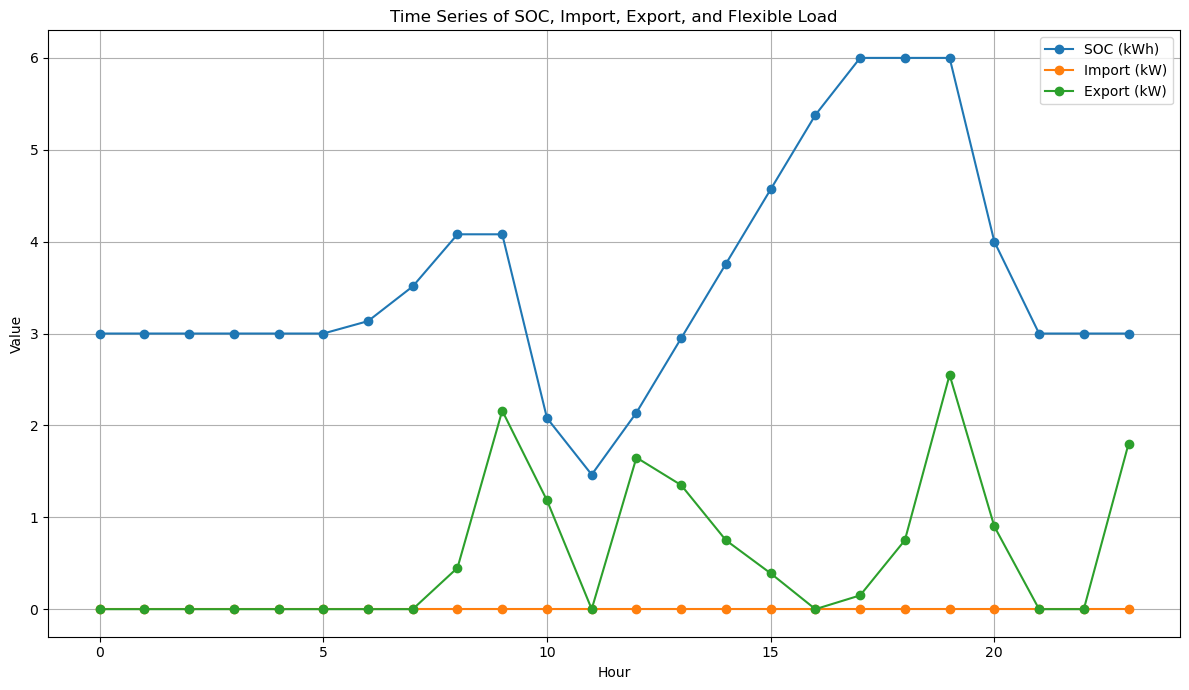

In [264]:
import matplotlib.pyplot as plt

# Extract results after optimization
hours = list(t)
soc = [SOC_t[i].X for i in hours]
imports = [x_imports[i].X for i in hours]
exports = [x_exports[i].X for i in hours]
discomfort = [delta_FFL[i].X for i in hours]
actual_profile = [x_FFL[i].X * max_load_FFL for i in hours]
solar_production = [x_solar[i].X for i in hours]


plt.figure(figsize=(12, 7))
plt.plot(hours, soc, label="SOC (kWh)", marker='o')
plt.plot(hours, imports, label="Import (kW)", marker='o')
plt.plot(hours, exports, label="Export (kW)", marker='o')
#plt.plot(hours, ffl, label="Flexible Load (kW)", marker='o')
#plt.plot(hours, discomfort, label="Discomfort (kW)", marker='o')
#plt.plot(hours, max_FFL*np.array(hourly_profile), label="Desired Load Profile (kW)", marker = "*", color='red')
#plt.plot(hours, np.array(actual_profile), label="Actual Load Profile (kW)", linestyle='--', color='blue')
plt.xlabel("Hour")
plt.ylabel("Value")
plt.title("Time Series of SOC, Import, Export, and Flexible Load")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

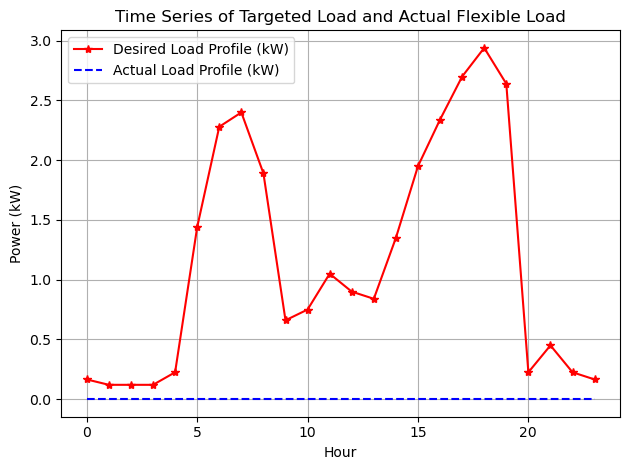

In [265]:
plt.plot(hours, max_load_FFL*np.array(load_profile_consumer), label="Desired Load Profile (kW)", marker = "*", color='red')
plt.plot(hours, np.array(actual_profile), label="Actual Load Profile (kW)", linestyle='--', color='blue')
plt.xlabel("Hour")
plt.ylabel("Power (kW)")
plt.title("Time Series of Targeted Load and Actual Flexible Load")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Time Series of Absolute Discomfort')

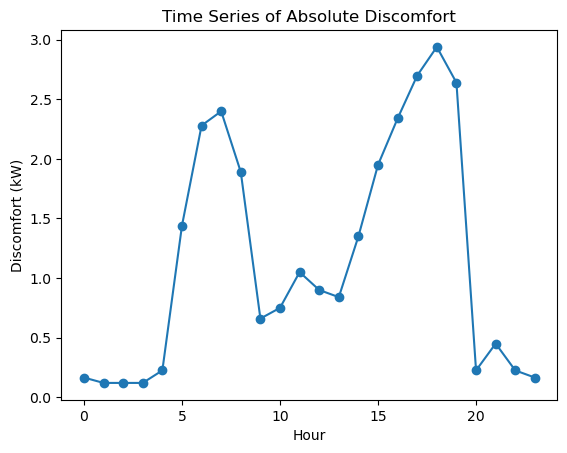

In [266]:
plt.plot(hours, discomfort, label="Discomfort (kW)", marker='o')
plt.xlabel("Hour")
plt.ylabel("Discomfort (kW)")
plt.title("Time Series of Absolute Discomfort")

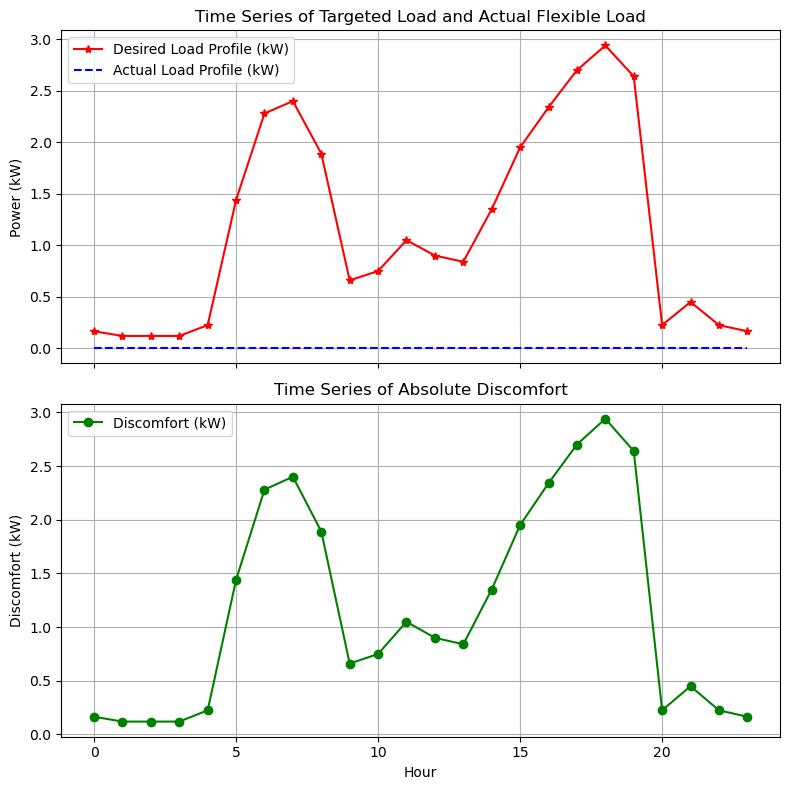

In [267]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# --- First subplot: Load profiles ---
axs[0].plot(hours, max_load_FFL*np.array(load_profile_consumer), 
            label="Desired Load Profile (kW)", marker="*", color='red')
axs[0].plot(hours, np.array(actual_profile), 
            label="Actual Load Profile (kW)", linestyle='--', color='blue')
axs[0].set_ylabel("Power (kW)")
axs[0].set_title("Time Series of Targeted Load and Actual Flexible Load")
axs[0].legend()
axs[0].grid(True)

# --- Second subplot: Discomfort ---
axs[1].plot(hours, discomfort, label="Discomfort (kW)", marker='o', color='green')
axs[1].set_xlabel("Hour")
axs[1].set_ylabel("Discomfort (kW)")
axs[1].set_title("Time Series of Absolute Discomfort")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


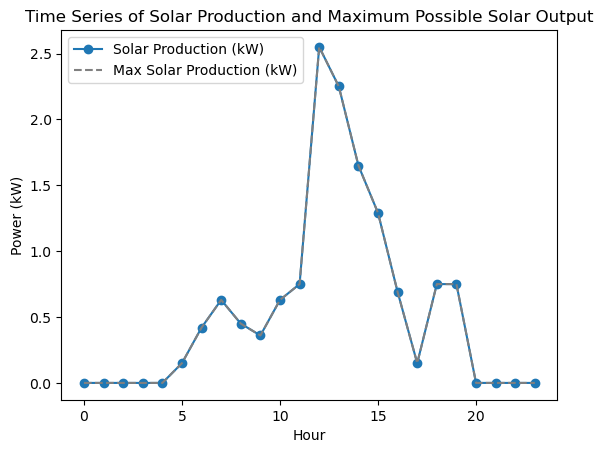

In [268]:
plt.plot(hours, solar_production, label="Solar Production (kW)", marker='o')
plt.plot(hours, np.array(Solar_CF)* max_power_solar, label="Max Solar Production (kW)", linestyle='--', color='gray')
plt.xlabel("Hour")
plt.ylabel("Power (kW)")
plt.title("Time Series of Solar Production and Maximum Possible Solar Output")
plt.legend()

In [269]:
np.array(load_profile_consumer)*max_load_FFL

array([0.165, 0.12 , 0.12 , 0.12 , 0.225, 1.44 , 2.28 , 2.4  , 1.89 ,
       0.66 , 0.75 , 1.05 , 0.9  , 0.84 , 1.35 , 1.95 , 2.34 , 2.7  ,
       2.94 , 2.64 , 0.225, 0.45 , 0.225, 0.165])

In [270]:
np.array(actual_profile)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

### Sensitivty Analysis:

In [271]:
prosumer_optimization(price_import, price_export, electricity_price,penalty_excess_import, penalty_excess_export,weight_discomfort = 1)

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 310 rows, 240 columns and 710 nonzeros
Model fingerprint: 0x86921cab
Coefficient statistics:
  Matrix range     [9e-01, 3e+00]
  Objective range  [4e-01, 1e+01]
  Bounds range     [9e-01, 6e+00]
  RHS range        [1e-01, 1e+03]
Presolve removed 169 rows and 14 columns
Presolve time: 0.01s
Presolved: 141 rows, 226 columns, 412 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2060000e+31   4.055000e+31   2.206000e+01      0s
     115   -9.9018333e+00   0.000000e+00   0.000000e+00      0s

Solved in 115 iterations and 0.01 seconds (0.00 work units)
Optimal objective -9.901833333e+00


(<gurobi.Model Continuous instance Prosumer_Continuous: 310 constrs, 240 vars, Parameter changes: Username=(user-defined), LicenseID=2602524>,
 {0: <gurobi.Var imported_power_kW[0] (value 0.0)>,
  1: <gurobi.Var imported_power_kW[1] (value 0.0)>,
  2: <gurobi.Var imported_power_kW[2] (value 0.0)>,
  3: <gurobi.Var imported_power_kW[3] (value 0.0)>,
  4: <gurobi.Var imported_power_kW[4] (value 0.0)>,
  5: <gurobi.Var imported_power_kW[5] (value 0.0)>,
  6: <gurobi.Var imported_power_kW[6] (value 0.0)>,
  7: <gurobi.Var imported_power_kW[7] (value 0.0)>,
  8: <gurobi.Var imported_power_kW[8] (value 0.0)>,
  9: <gurobi.Var imported_power_kW[9] (value 0.0)>,
  10: <gurobi.Var imported_power_kW[10] (value 0.0)>,
  11: <gurobi.Var imported_power_kW[11] (value 0.0)>,
  12: <gurobi.Var imported_power_kW[12] (value 0.0)>,
  13: <gurobi.Var imported_power_kW[13] (value 0.0)>,
  14: <gurobi.Var imported_power_kW[14] (value 0.0)>,
  15: <gurobi.Var imported_power_kW[15] (value 0.0)>,
  16: <gurobi

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 310 rows, 240 columns and 710 nonzeros
Model fingerprint: 0x3c5fedcd
Coefficient statistics:
  Matrix range     [9e-01, 3e+00]
  Objective range  [4e-01, 1e+01]
  Bounds range     [9e-01, 6e+00]
  RHS range        [1e-01, 1e+03]
Presolve removed 169 rows and 14 columns
Presolve time: 0.00s
Presolved: 141 rows, 226 columns, 412 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2060000e+31   4.055000e+31   2.206000e+01      0s
     122   -2.1890937e+01   0.000000e+00   0.000000e+00      0s

Solved in 122 iterations and 0.01 seconds (0.00 work units)
Optimal objective -2.189093704e+01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: A

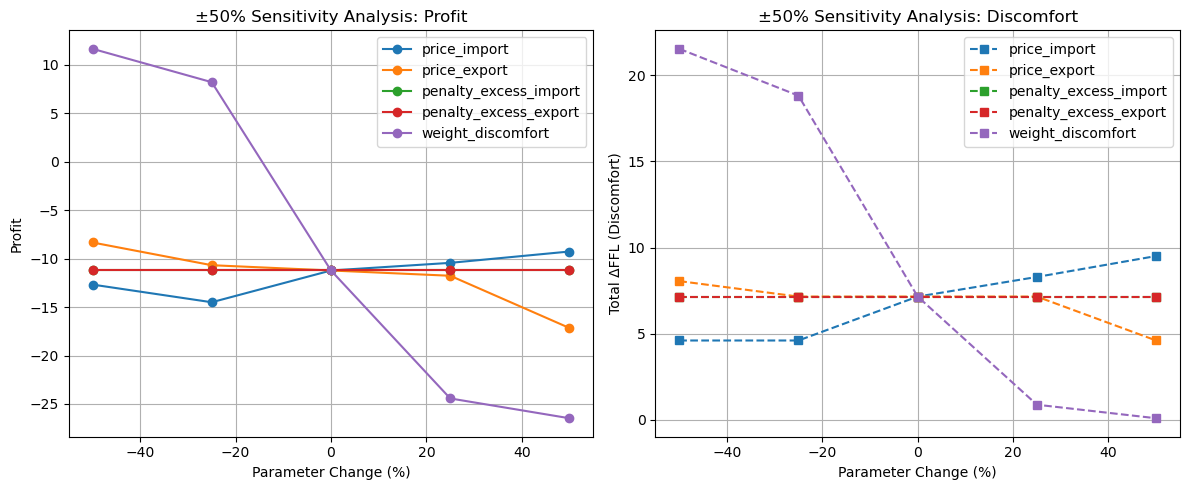

In [272]:
import pandas as pd
import matplotlib.pyplot as plt

def sensitivity_analysis_50pct(electricity_price, base_weight_discomfort=2.0):
    results = []
    
    # Parameters to vary
    params_to_vary = ["price_import", "price_export",
                      "penalty_excess_import", "penalty_excess_export",
                      "weight_discomfort"]
    multipliers = [0.5,0.75,1,1.25,1.5]

    for param in params_to_vary:
        for m in multipliers:
            # Copy current parameters and scale one
            test_params = {
                "price_import": price_import,
                "price_export": price_export,
                "electricity_price": electricity_price,
                "penalty_excess_import": penalty_excess_import,
                "penalty_excess_export": penalty_excess_export,
                "weight_discomfort": base_weight_discomfort
            }
            test_params[param] *= m

            # Run optimization
            model, *_ , profit, total_discomfort = prosumer_optimization(**test_params)

            results.append({
                "parameter": param,
                "multiplier": m,
                "profit": float(profit),
                "discomfort": float(total_discomfort)
            })

    return pd.DataFrame(results)

# --- Run the sensitivity analysis ---
df_sens = sensitivity_analysis_50pct(electricity_price, base_weight_discomfort=2.0)
print(df_sens)

# --- Separate plots for Profit and Discomfort with percentage x-axis ---
plt.figure(figsize=(12,5))

# Profit plot
plt.subplot(1,2,1)
for param in df_sens["parameter"].unique():
    subset = df_sens[df_sens["parameter"] == param]
    pct_change = (subset["multiplier"] - 1.0) * 100  # convert to %
    plt.plot(pct_change, subset["profit"], marker='o', label=param)
plt.xlabel("Parameter Change (%)")
plt.ylabel("Profit")
plt.title("±50% Sensitivity Analysis: Profit")
plt.grid(True)
plt.legend()

# Discomfort plot
plt.subplot(1,2,2)
for param in df_sens["parameter"].unique():
    subset = df_sens[df_sens["parameter"] == param]
    pct_change = (subset["multiplier"] - 1.0) * 100  # convert to %
    plt.plot(pct_change, subset["discomfort"], marker='s', linestyle="--", label=param)
plt.xlabel("Parameter Change (%)")
plt.ylabel("Total ΔFFL (Discomfort)")
plt.title("±50% Sensitivity Analysis: Discomfort")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


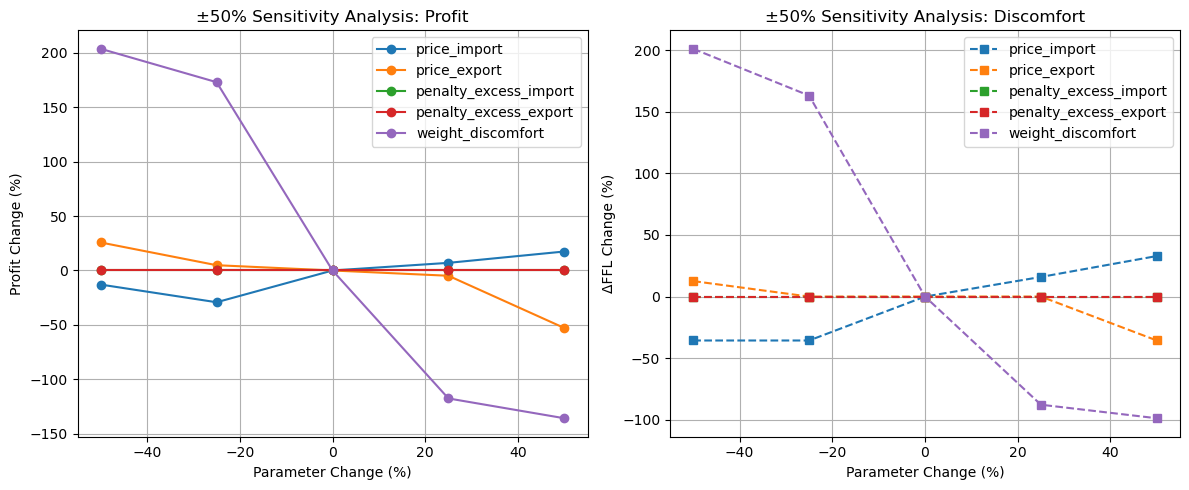

In [273]:
# --- Separate plots with % change on both axes ---
plt.figure(figsize=(12,5))

# Compute base case values
base_profit = df_sens[df_sens["multiplier"] == 1.0]["profit"].values[0]
base_discomfort = df_sens[df_sens["multiplier"] == 1.0]["discomfort"].values[0]

# Profit plot
plt.subplot(1,2,1)
for param in df_sens["parameter"].unique():
    subset = df_sens[df_sens["parameter"] == param]
    pct_change_x = (subset["multiplier"] - 1.0) * 100  # x-axis: parameter change
    pct_change_y = (subset["profit"] - base_profit) / abs(base_profit) * 100  # y-axis: profit change %
    plt.plot(pct_change_x, pct_change_y, marker='o', label=param)
plt.xlabel("Parameter Change (%)")
plt.ylabel("Profit Change (%)")
plt.title("±50% Sensitivity Analysis: Profit")
plt.grid(True)
plt.legend()

# Discomfort plot
plt.subplot(1,2,2)
for param in df_sens["parameter"].unique():
    subset = df_sens[df_sens["parameter"] == param]
    pct_change_x = (subset["multiplier"] - 1.0) * 100  # x-axis: parameter change
    pct_change_y = (subset["discomfort"] - base_discomfort) / abs(base_discomfort) * 100  # y-axis: discomfort change %
    plt.plot(pct_change_x, pct_change_y, marker='s', linestyle="--", label=param)
plt.xlabel("Parameter Change (%)")
plt.ylabel("ΔFFL Change (%)")
plt.title("±50% Sensitivity Analysis: Discomfort")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 310 rows, 240 columns and 710 nonzeros
Model fingerprint: 0x3c5fedcd
Coefficient statistics:
  Matrix range     [9e-01, 3e+00]
  Objective range  [4e-01, 1e+01]
  Bounds range     [9e-01, 6e+00]
  RHS range        [1e-01, 1e+03]
Presolve removed 169 rows and 14 columns
Presolve time: 0.02s
Presolved: 141 rows, 226 columns, 412 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2060000e+31   4.055000e+31   2.206000e+01      0s
     122   -2.1890937e+01   0.000000e+00   0.000000e+00      0s

Solved in 122 iterations and 0.02 seconds (0.00 work units)
Optimal objective -2.189093704e+01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model

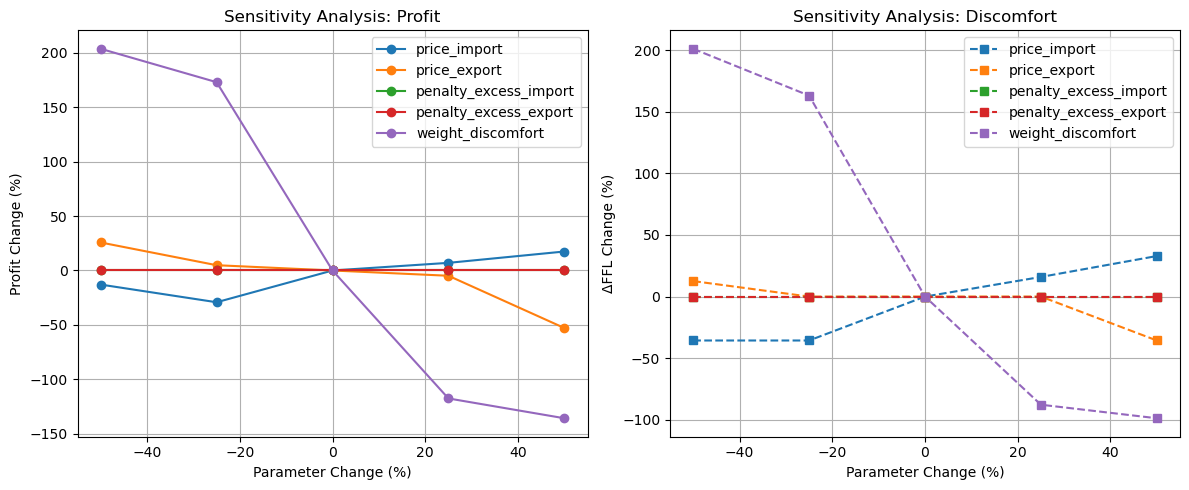

                parameter  multiplier     profit  discomfort
0            price_import        0.50 -12.680937    4.605000
1            price_import        0.75 -14.504016    4.605000
2            price_import        1.00 -11.227094    7.155000
3            price_import        1.25 -10.440150    8.295000
4            price_import        1.50  -9.270150    9.510000
5            price_export        0.50  -8.338094    8.055000
6            price_export        0.75 -10.682594    7.155000
7            price_export        1.00 -11.227094    7.155000
8            price_export        1.25 -11.771594    7.155000
9            price_export        1.50 -17.161094    4.605000
10  penalty_excess_import        0.50 -11.227094    7.155000
11  penalty_excess_import        0.75 -11.227094    7.155000
12  penalty_excess_import        1.00 -11.227094    7.155000
13  penalty_excess_import        1.25 -11.227094    7.155000
14  penalty_excess_import        1.50 -11.227094    7.155000
15  penalty_excess_expor

In [274]:
# Scale parameter safely
def scale_param(param_value, multiplier):
    if isinstance(param_value, (list, pd.Series)):
        return [x * multiplier for x in param_value]
    else:
        return param_value * multiplier  # scalar

def sensitivity_analysis(electricity_price, base_weight_discomfort=2.0):
    results = []

    # Parameters to vary
    params_to_vary = ["price_import", "price_export",
                      "penalty_excess_import", "penalty_excess_export",
                      "weight_discomfort"]
    multipliers = [0.5,0.75,1,1.25,1.5]  # -50%, -25%, 0%, +25%, +50%

    for param in params_to_vary:
        for m in multipliers:
            # Copy current parameters safely
            test_params = {
                "price_import": scale_param(price_import, m if param=="price_import" else 1.0),
                "price_export": scale_param(price_export, m if param=="price_export" else 1.0),
                "electricity_price": electricity_price,
                "penalty_excess_import": scale_param(penalty_excess_import, m if param=="penalty_excess_import" else 1.0),
                "penalty_excess_export": scale_param(penalty_excess_export, m if param=="penalty_excess_export" else 1.0),
                "weight_discomfort": scale_param(base_weight_discomfort, m if param=="weight_discomfort" else 1.0)
            }

            # Run optimization
            model, *_ , profit, total_discomfort = prosumer_optimization(**test_params)

            results.append({
                "parameter": param,
                "multiplier": m,
                "profit": float(profit),
                "discomfort": float(total_discomfort)
            })

    df_sens = pd.DataFrame(results)

    # --- Compute base case values for % change ---
    base_profit = df_sens[df_sens["multiplier"] == 1.0]["profit"].values[0]
    base_discomfort = df_sens[df_sens["multiplier"] == 1.0]["discomfort"].values[0]

    # --- Separate plots with % change on both axes ---
    plt.figure(figsize=(12,5))

    # Profit plot
    plt.subplot(1,2,1)
    for param in df_sens["parameter"].unique():
        subset = df_sens[df_sens["parameter"] == param]
        pct_change_x = (subset["multiplier"] - 1.0) * 100
        pct_change_y = (subset["profit"] - base_profit) / abs(base_profit) * 100
        plt.plot(pct_change_x, pct_change_y, marker='o', label=param)
    plt.xlabel("Parameter Change (%)")
    plt.ylabel("Profit Change (%)")
    plt.title("Sensitivity Analysis: Profit")
    plt.grid(True)
    plt.legend()

    # Discomfort plot
    plt.subplot(1,2,2)
    for param in df_sens["parameter"].unique():
        subset = df_sens[df_sens["parameter"] == param]
        pct_change_x = (subset["multiplier"] - 1.0) * 100
        pct_change_y = (subset["discomfort"] - base_discomfort) / abs(base_discomfort) * 100
        plt.plot(pct_change_x, pct_change_y, marker='s', linestyle="--", label=param)
    plt.xlabel("Parameter Change (%)")
    plt.ylabel("ΔFFL Change (%)")
    plt.title("Sensitivity Analysis: Discomfort")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return df_sens

# --- Run the sensitivity analysis ---
df_sens = sensitivity_analysis(electricity_price, base_weight_discomfort=2.0)
print(df_sens)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 310 rows, 240 columns and 710 nonzeros
Model fingerprint: 0x29884eef
Coefficient statistics:
  Matrix range     [9e-01, 3e+00]
  Objective range  [4e-01, 1e+01]
  Bounds range     [9e-01, 6e+00]
  RHS range        [1e-01, 1e+03]
Presolve removed 169 rows and 14 columns
Presolve time: 0.01s
Presolved: 141 rows, 226 columns, 412 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2060000e+31   4.055000e+31   2.206000e+01      0s
     114   -3.8054100e+00   0.000000e+00   0.000000e+00      0s

Solved in 114 iterations and 0.01 seconds (0.00 work units)
Optimal objective -3.805410000e+00
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: A

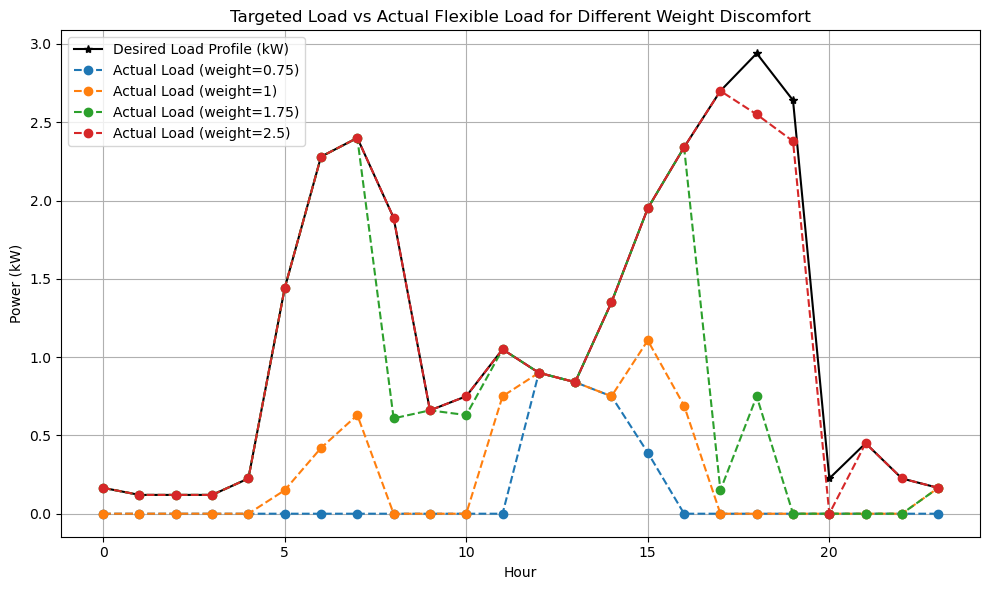

In [275]:
import matplotlib.pyplot as plt
import numpy as np

# Example: list of weight_discomfort values to test
weight_discomfort_values = [0.75,1,1.75,2.5]
actual_profiles = []  # store actual FFL profiles for each scenario

# Run optimization for each weight_discomfort
for w in weight_discomfort_values:
    model, x_imports, x_exports, x_FFL, x_solar, delta_FFL, SOC_t, x_charging, x_discharging, profit, total_discomfort = prosumer_optimization(
        price_import, price_export, electricity_price,
        penalty_excess_import, penalty_excess_export, weight_discomfort=w
    )
    # Convert x_FFL to actual kW
    actual_profiles.append([x_FFL[i].X * max_load_FFL for i in t])

# Plotting
plt.figure(figsize=(10,6))

# Desired load profile
plt.plot(hours, max_load_FFL*np.array(load_profile_consumer), 
         label="Desired Load Profile (kW)", marker="*", color='black')

# Actual profiles for different weight_discomfort
for w, profile in zip(weight_discomfort_values, actual_profiles):
    plt.plot(hours, profile, linestyle='--', marker='o', label=f"Actual Load (weight={w})")

plt.xlabel("Hour")
plt.ylabel("Power (kW)")
plt.title("Targeted Load vs Actual Flexible Load for Different Weight Discomfort")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Battery Invesmtent (Sizing)

In [321]:
capital_cost_battery =  1500 # DKK/KWh

In [380]:
import gurobipy as gp
from gurobipy import GRB

def prosumer_optimization(price_import,price_export,electricity_price,penalty_excess_import,
        penalty_excess_export,weight_discomfort,capital_cost_battery):
    """
    Prosumer optimization model including battery storage and discomfort.
    """

    model = gp.Model("Prosumer_Continuous")

    # === Decision Variables ===
    x_imports = model.addVars(t, name="imported_power_kW", lb=0)
    x_exports = model.addVars(t, name="exported_power_kW", lb=0)
    x_FFL = model.addVars(t, name="FFL_consumption_kW", lb=0, ub=1)  # scaled 0–1
    x_solar = model.addVars(t, name="solar_power_kW", lb=0)
    z_import_excess = model.addVars(t, name="excess_import_kW", lb=0)
    z_export_excess = model.addVars(t, name="excess_export_kW", lb=0)
    delta_FFL = model.addVars(t, name="delta_FFL", lb=0)
    SOC_t = model.addVars(t, name="SOC", lb=0)
    x_charging = model.addVars(t, name="charging_power_kW", lb=0)
    x_discharging = model.addVars(t, name="discharging_power_kW", lb=0)
    storage_capacity = model.addVar(name="battery_capacity_kWh", lb=0)

    # === Constraints ===
    for i in t:
        # FFL consumption limits
        model.addConstr(x_FFL[i] * max_load_FFL >= min_load_FFL, name=f"FFL_min_{i}")
        model.addConstr(x_FFL[i] * max_load_FFL <= max_load_FFL, name=f"FFL_max_{i}")

        # Battery power limits
        model.addConstr(x_charging[i] <= max_charging_power_ratio * storage_capacity, name=f"charging_limit_{i}")
        model.addConstr(x_discharging[i] <= max_discharging_power_ratio * storage_capacity, name=f"discharging_limit_{i}")

        # SOC capacity bound
        model.addConstr(SOC_t[i] <= storage_capacity, name=f"SOC_limit_{i}")

        # Solar generation constraint
        model.addConstr(x_solar[i] <= Solar_CF[i] * max_power_solar, name=f"solar_max_{i}")

        # Energy balance (supply = demand)
        model.addConstr(
            x_imports[i] - x_exports[i] + x_solar[i] + x_discharging[i] - x_charging[i]
            == x_FFL[i] * max_load_FFL,
            name=f"energy_balance_{i}"
        )

        # Excess import/export constraints
        model.addConstr(z_import_excess[i] >= x_imports[i] - max_import, name=f"excess_import_{i}")
        model.addConstr(z_export_excess[i] >= x_exports[i] - max_export, name=f"excess_export_{i}")

        # Discomfort
        model.addConstr(delta_FFL[i] >= (x_FFL[i] - load_profile_consumer[i]) * max_load_FFL, name=f"discomfort_pos_{i}")
        model.addConstr(delta_FFL[i] >= (load_profile_consumer[i] - x_FFL[i]) * max_load_FFL, name=f"discomfort_neg_{i}")

        # SOC dynamics
        if i == t[0]:
            model.addConstr(SOC_t[i] == SOC_initial * storage_capacity, name="initial_soc")
        else:
            model.addConstr(
                SOC_t[i] == SOC_t[i-1] 
                + (x_charging[i-1] * charging_efficiency) 
                - (x_discharging[i-1] / discharging_efficiency),
                name=f"SOC_dynamics_{i}"
            )
        if i == t[-1]:
            model.addConstr(SOC_t[i] == SOC_final * storage_capacity, name="final_soc")

        # Ramp constraints
        if i > t[0]:
            model.addConstr(
                (x_FFL[i] - x_FFL[i-1]) * max_load_FFL <= max_ramp_up_rate_FFL * max_load_FFL,
                name=f"FFL_ramp_up_{i}"
            )
            model.addConstr(
                (x_FFL[i-1] - x_FFL[i]) * max_load_FFL <= max_ramp_down_rate_FFL * max_load_FFL,
                name=f"FFL_ramp_down_{i}"
            )
            model.addConstr(
                x_solar[i] - x_solar[i-1] <= max_ramp_up_rate_solar * max_power_solar,
                name=f"solar_ramp_up_{i}"
            )
            model.addConstr(
                x_solar[i-1] - x_solar[i] <= max_ramp_down_rate_solar * max_power_solar,
                name=f"solar_ramp_down_{i}"
            )

    # Minimum total daily FFL energy (optional)
    model.addConstr(gp.quicksum(x_FFL[i] * max_load_FFL for i in t) >= 0, name="FFL_min_total_energy")

    # === Objective Function: Maximize Profit ===
    obj = gp.quicksum(
        (-price_import - electricity_price[i]) * x_imports[i]
        - penalty_excess_import * z_import_excess[i]
        + (electricity_price[i] - price_export) * x_exports[i]
        - penalty_excess_export * z_export_excess[i]
        - weight_discomfort * delta_FFL[i]
        for i in t
    ) - capital_cost_battery * storage_capacity

    model.setObjective(obj, GRB.MAXIMIZE)

    # === Optimize ===
    model.optimize()

    # === Return Results ===
    profit_value = model.ObjVal
    total_discomfort = sum(delta_FFL[i].X for i in t)

    return model, x_imports, x_exports, x_FFL, x_solar, delta_FFL, SOC_t, x_charging, x_discharging, profit_value, total_discomfort, storage_capacity.X


In [381]:
model, x_imports, x_exports, x_FFL, x_solar, delta_FFL, SOC_t, x_charging, x_discharging, profit_value, total_discomfort, storage_capacity = prosumer_optimization(price_import, price_export, electricity_price,
                          penalty_excess_import, penalty_excess_export,weight_discomfort = 1,capital_cost_battery = 0.0003*capital_cost_battery)

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 382 rows, 241 columns and 856 nonzeros
Model fingerprint: 0x041bf8f9
Coefficient statistics:
  Matrix range     [1e-01, 3e+00]
  Objective range  [4e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+03]
Presolve removed 169 rows and 11 columns
Presolve time: 0.01s
Presolved: 213 rows, 230 columns, 559 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2060000e+31   3.075000e+31   2.206000e+01      0s
     145   -1.0195260e+01   0.000000e+00   0.000000e+00      0s

Solved in 145 iterations and 0.02 seconds (0.00 work units)
Optimal objective -1.019526000e+01


In [382]:
storage_capacity

21.546